In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rc('image', cmap='gist_gray')
import pandas as pd
import datetime

In [2]:
valid_pred = "Organized_Outputs/3_Level2_Data/ConvLSTM_Dims/ConvLSTM/valid_prediction0.1 (7).npy"
valid_true = "Organized_Outputs/3_Level2_Data/ConvLSTM_Dims/ConvLSTM/valid_truth0.1 (7).npy"
train_pred = "Organized_Outputs/3_Level2_Data/ConvLSTM_Dims/ConvLSTM/train_prediction0.1 (7).npy"
train_true = "Organized_Outputs/3_Level2_Data/ConvLSTM_Dims/ConvLSTM/train_truth0.1 (7).npy"

In [3]:
volcs = ["Erebus", "ErtaAle", "Etna", "Kilauea", "Masaya",
         "Nyamuragira", "Nyiragongo", "Pacaya", "Puuoo"]
volc_indicator = np.concatenate([np.repeat("Erebus", 71),
                                 np.repeat("ErtaAle", 38),
                                 np.repeat("Etna", 28),
                                 np.repeat("Kilauea", 33),
                                 np.repeat("Masaya", 9),
                                 np.repeat("Nyamuragira", 11),
                                 np.repeat("Nyiragongo", 15),
                                 np.repeat("Pacaya", 10),
                                 np.repeat("Puuoo", 25)])
breakpoints = np.cumsum([71, 38, 28, 33, 9, 11, 15, 10, 25])

# Examining validation set

In [4]:
preds = np.load(valid_pred)
true = np.load(valid_true)
preds.shape, true.shape

((240, 1, 1, 96, 96), (240, 1, 1, 96, 96))

# Validation set range of values

In [5]:
preds.max()

11.305653

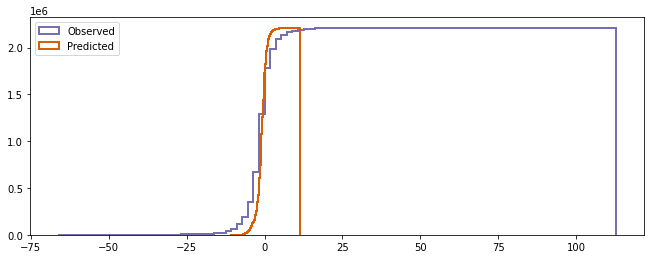

In [6]:
plt.figure(figsize = (11, 4))
a = plt.hist(true.flatten(), bins = 100,
         histtype = 'step', linestyle = '-',
         linewidth = 2, color = '#7570b3', cumulative = True, label = 'Observed')
b = plt.hist(preds.flatten(), bins = 100,
         histtype = 'step', cumulative = True,
         linewidth = 2, color = '#d95f02', label = 'Predicted')
plt.legend(loc = 'upper left');

# View some of the validation set images

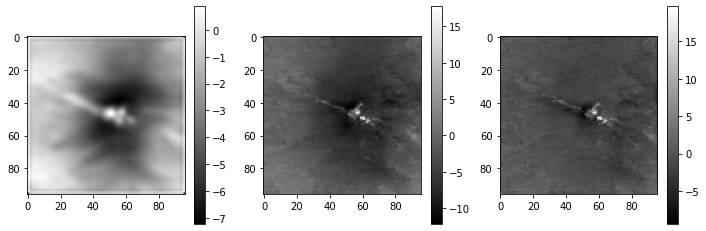

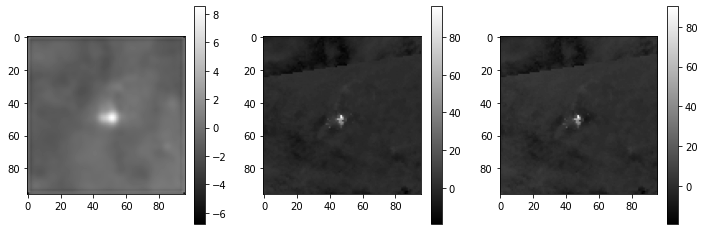

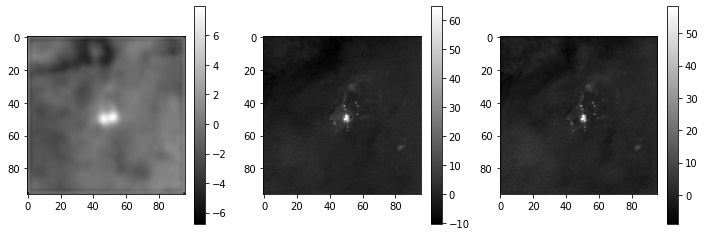

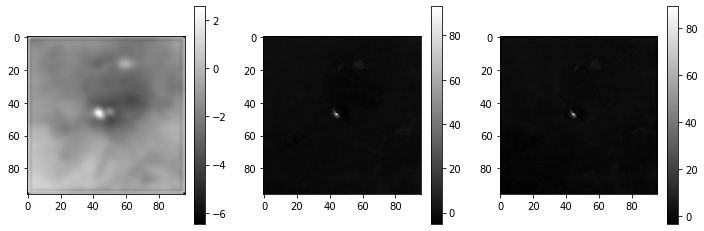

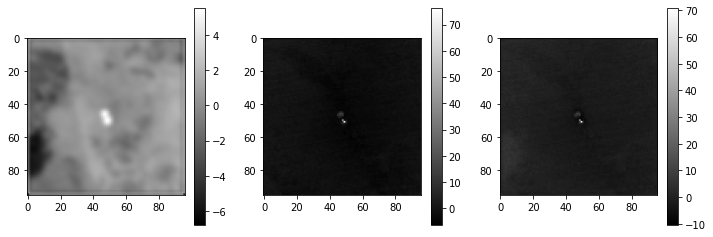

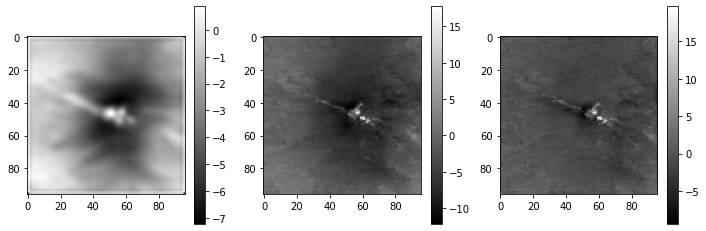

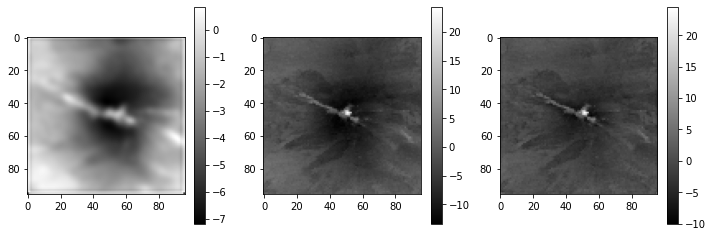

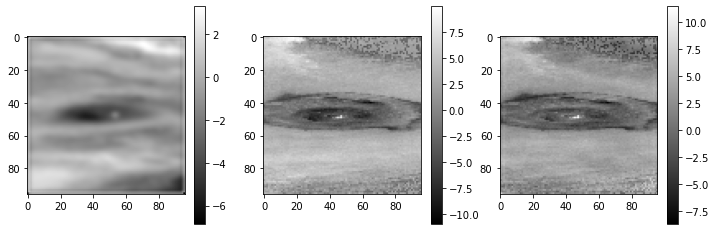

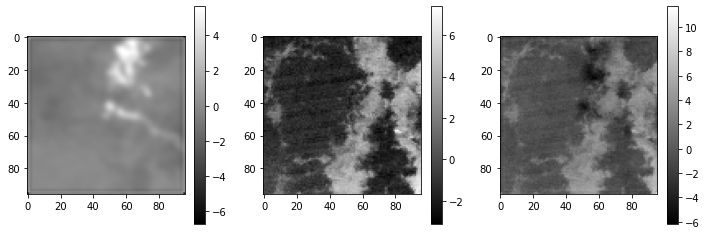

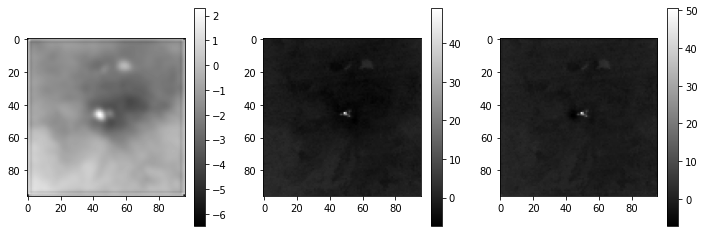

In [7]:
for i in range(10):
    i = np.random.choice(len(preds) - 1)
    f, axarr = plt.subplots(1,3)
    f.set_figheight(4)
    f.set_figwidth(12)
    a = axarr[0].imshow(preds[i, 0, 0, :, :])
    f.colorbar(a, ax=axarr[0])
    b = axarr[1].imshow(true[i, 0, 0, :, :])
    f.colorbar(b, ax=axarr[1])
    c = axarr[2].imshow(true[i, 0, 0, :, :] - preds[i+1, 0, 0, :, :])
    f.colorbar(c, ax=axarr[2])

# Summary metrics - RMSE and SSIM

In [8]:
np.sqrt(np.sum((true - preds)**2) / len(true.flatten()))

4.299824745096208

In [9]:
from skimage.metrics import structural_similarity as ssim

In [10]:
ssim_sk_ls = []
for i in range(preds.shape[0]):
    ssim_sk_ls.append(ssim(preds[i, 0, 0], true[i, 0, 0]))

In [11]:
np.mean(ssim_sk_ls)

0.056563651488481824

# Deriving some volcanology info - max Temperature

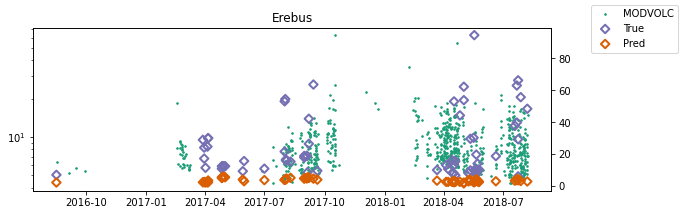

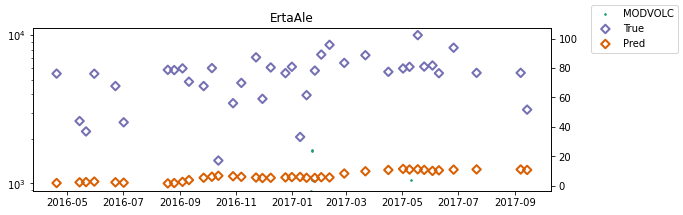

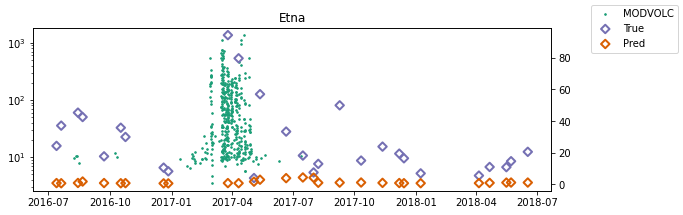

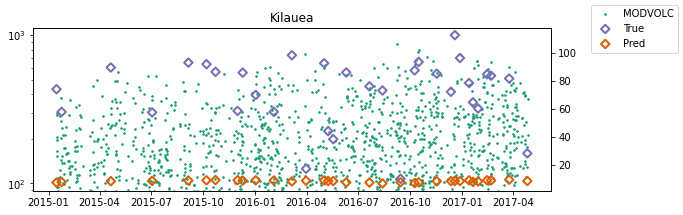

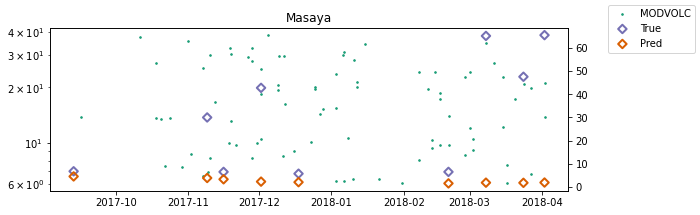

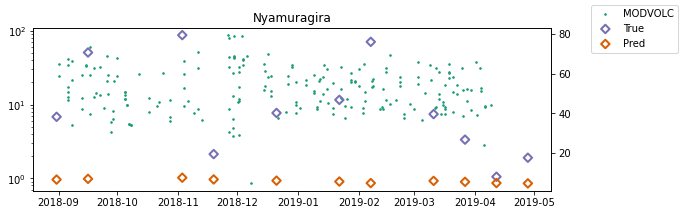

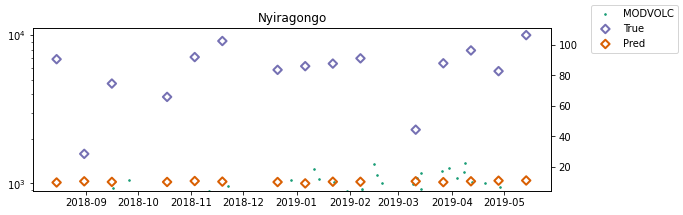

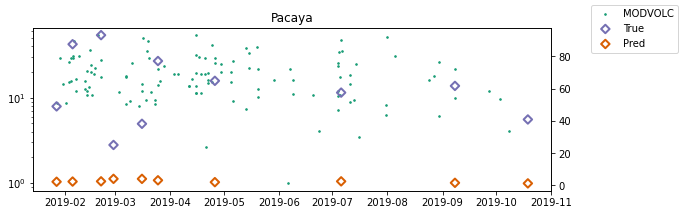

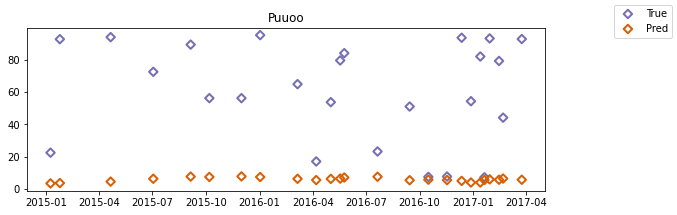

In [12]:
# Maximum temperature - true
max_T_ls = []
for i in range(len(true)):
    max_T_ls.append(np.max(true[i]))
# Maximum temperature - predicted    
max_T_ls2 = []
for i in range(len(preds)):
    max_T_ls2.append(np.max(preds[i]))

last_break = 0
count = 0
for breaks in breakpoints:
    
    obs_subset = max_T_ls[last_break:breaks]
    pred_subset = max_T_ls2[last_break:breaks]
    
    vol = volcs[count]
    good_df = pd.read_csv('data/' + vol + '/good_df.csv')
    if vol == 'Erebus':
        good_df['acquisition_datetimes'] = [file.split('_')[2] for file in good_df['nighttime_volcano_files']]
        good_df = good_df[good_df.acquisition_datetimes != '00304102013143221'] 
        good_df = good_df[good_df.acquisition_datetimes != '00308162018142109']
        good_df = good_df.reset_index()
    dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in good_df['dates']]
    # Reproducing index choosing from training script
    train_percent = 0.70
    out_samp_perc = 0.15
    num_input_scenes = 6
    train_n = int(np.floor((len(good_df) - num_input_scenes)*train_percent))
    out_n = int(np.floor((len(good_df) - num_input_scenes)*out_samp_perc))
    df_start = train_n + num_input_scenes
    df_end = train_n + out_n + num_input_scenes
    # Getting the dates for the validation sets' y indices
    relevant_dates = dates[df_start:df_end]

    fig, ax1 = plt.subplots()
    fig.set_figheight(3)
    fig.set_figwidth(9)
    fig.subplots_adjust(left = 0, right = 0.8)
    # Getting supplementary modvolc data if available
    if vol != 'Puuoo':
        modvolc_alerts_fn = 'supplementary_data/modvolc_alerts/modis_alert_data_' + vol + '.txt'
        modvolc_alerts_df = pd.read_csv(modvolc_alerts_fn, sep = '\s+')
        modvolc_dates = [datetime.datetime.utcfromtimestamp(date) for date in modvolc_alerts_df['UNIX_Time']]
        ax1.scatter(modvolc_dates, modvolc_alerts_df['Excess'], s = 10, color = '#1b9e77', marker = '.', label = 'MODVOLC')
        ax1.set_yscale('log')
        ax2 = ax1.twinx() 
        ax2.scatter(relevant_dates, obs_subset, label = 'True', linewidth = 2, edgecolor = '#7570b3', color = 'none', marker = 'D')
        ax2.scatter(relevant_dates, pred_subset, label = 'Pred', linewidth = 2, edgecolor = '#d95f02', color = 'none', marker = 'D')
    else:
        ax1.scatter(relevant_dates, obs_subset, label = 'True', linewidth = 2, edgecolor = '#7570b3', color = 'none', marker = 'D')
        ax1.scatter(relevant_dates, pred_subset, label = 'Pred', linewidth = 2, edgecolor = '#d95f02', color = 'none', marker = 'D')
    fig.legend()
    plt.title(vol);
    last_break = breaks
    count += 1

In [13]:
max_T_ls = np.asarray(max_T_ls)
max_T_ls2 = np.asarray(max_T_ls2)
np.sqrt(np.sum((max_T_ls - max_T_ls2)**2) / len(max_T_ls))

52.51432840187523

# Number of hotspots (>10, >20, >35) and distance from summit

In [14]:
def get_num_hotspots_and_distance_from_summit(observed_imgs, pred_imgs, hot):
    
    # Assign each pixel a value corresp. to distance from the summit/center
    distance_from_summit = np.zeros((96, 96))
    for i in range(distance_from_summit.shape[0]):
        for j in range(distance_from_summit.shape[1]):
            distance_from_summit[i, j] = 90*np.sqrt((i-48)**2 + (j-48)**2)
            
    # Empty lists to store number of hotspots and furtherest hotspot from summit
    # for observed and predicted images
    distance_from_summit_ls = []
    num_hotspots_ls = []
    distance_from_summit_ls_pred = []
    num_hotspots_ls_pred = []
    # Binary indications of exceedance
    over = (observed_imgs >= hot).astype(int)
    over_pred = (pred_imgs >= hot).astype(int)
    
    # For each image
    for i in range(len(observed_imgs)):
        # Count the number of exceeding pixels
        num_hotspots_ls.append(np.sum(over[i, 0, 0]))
        num_hotspots_ls_pred.append(np.sum(over_pred[i, 0, 0]))
        # Find the distance of the furthest hotspot from the summit
        over[i, 0, 0] = over[i, 0, 0]*distance_from_summit
        distance_from_summit_ls.append(over[i, 0, 0].max())
        over_pred[i, 0, 0] = over_pred[i, 0, 0]*distance_from_summit
        distance_from_summit_ls_pred.append(over_pred[i, 0, 0].max())
        
    # Plot
    last_break = 0
    count = 0
    for breaks in breakpoints:
        num_hot_subset = num_hotspots_ls[last_break:breaks]
        num_hot_subset_pred = num_hotspots_ls_pred[last_break:breaks]
        distance_subset = distance_from_summit_ls[last_break:breaks]
        distance_subset_pred = distance_from_summit_ls_pred[last_break:breaks]

        vol = volcs[count]
        good_df = pd.read_csv('data/' + vol + '/good_df.csv')
        if vol == 'Erebus':
            good_df['acquisition_datetimes'] = [file.split('_')[2] for file in good_df['nighttime_volcano_files']]
            good_df = good_df[good_df.acquisition_datetimes != '00304102013143221'] 
            good_df = good_df[good_df.acquisition_datetimes != '00308162018142109']
            good_df = good_df.reset_index()
        dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in good_df['dates']]
        # Reproducing index choosing from training script
        train_percent = 0.70
        out_samp_perc = 0.15
        num_input_scenes = 6
        train_n = int(np.floor((len(good_df) - num_input_scenes)*train_percent))
        out_n = int(np.floor((len(good_df) - num_input_scenes)*out_samp_perc))
        df_start = train_n + num_input_scenes
        df_end = train_n + out_n + num_input_scenes
        # Getting the dates for the validation sets' y indices
        relevant_dates = dates[df_start:df_end]

        f, axarr = plt.subplots(1,2)
        f.set_figheight(3)
        f.set_figwidth(15)
        axarr[0].scatter(relevant_dates, num_hot_subset, label = 'True', color = 'none', linewidth = 2, edgecolor = '#7570b3', marker = 'D')
        axarr[0].scatter(relevant_dates, num_hot_subset_pred, label = 'Pred', color = 'none', linewidth = 2, edgecolor = '#d95f02', marker = 'D')
        axarr[0].legend()
        axarr[0].set_title(volc_indicator[last_break] + '\nNumber of hotspots\nhot >= ' + str(hot))
        axarr[1].scatter(relevant_dates, distance_subset, label = 'True', color = 'none', linewidth = 2, edgecolor = '#7570b3', marker = 'D')
        axarr[1].scatter(relevant_dates, distance_subset_pred, label = 'Pred', color = 'none', linewidth = 2, edgecolor = '#d95f02', marker = 'D')
        axarr[1].legend()
        axarr[1].set_title(volc_indicator[last_break] + '\nDistance of furthest hotspot from summit\nhot >= ' + str(hot))
        last_break = breaks
        count += 1

    num_hotspots_ls = np.asarray(num_hotspots_ls)
    num_hotspots_ls_pred = np.asarray(num_hotspots_ls_pred)
    distance_from_summit_ls = np.asarray(distance_from_summit_ls)
    distance_from_summit_ls_pred = np.asarray(distance_from_summit_ls_pred)
    print("Metrics for hotspot >=", hot)
    print("\tRMSE for number of hotspots:\n\t\t",
          np.sqrt(np.sum((num_hotspots_ls - num_hotspots_ls_pred)**2) / len(num_hotspots_ls)))
    print("\tRMSE for distance of furthest hotspot from summit:\n\t\t",
          np.sqrt(np.sum((distance_from_summit_ls - distance_from_summit_ls_pred)**2) / len(distance_from_summit_ls)),
         '\n')

Metrics for hotspot >= 35
	RMSE for number of hotspots:
		 25.3465152108398
	RMSE for distance of furthest hotspot from summit:
		 1513.0820946002896 



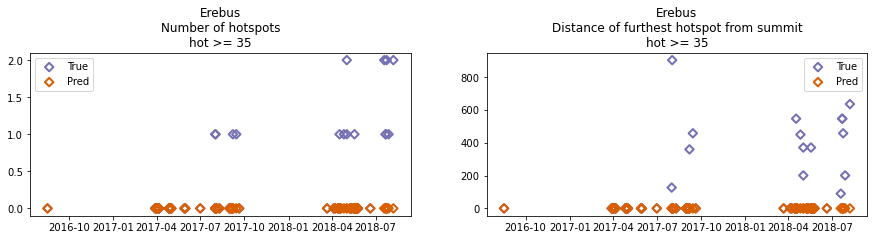

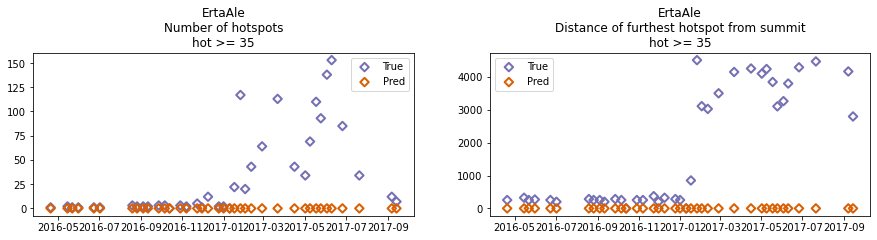

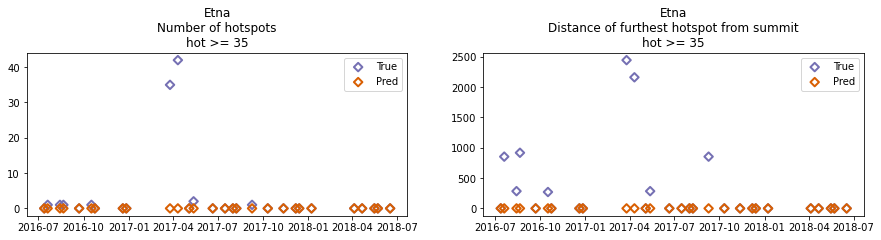

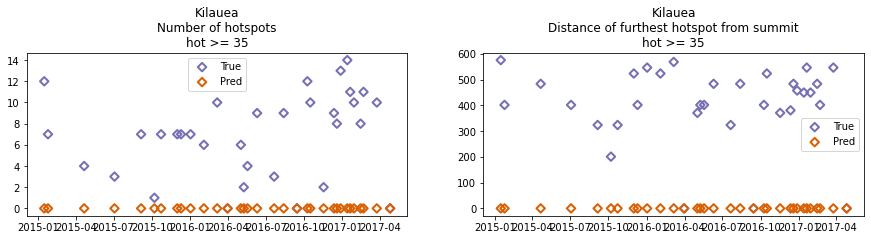

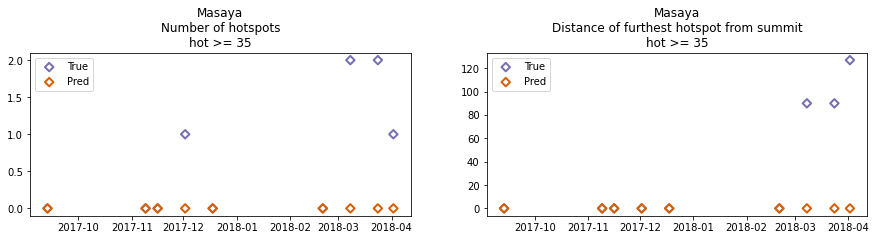

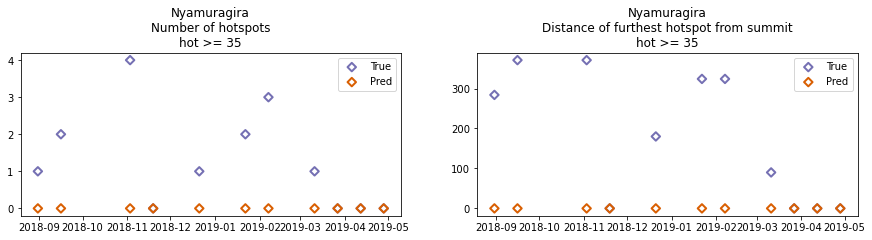

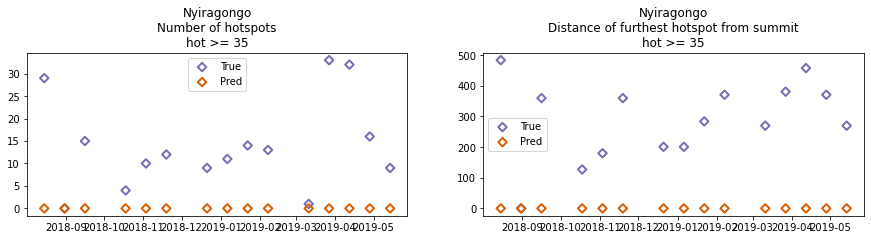

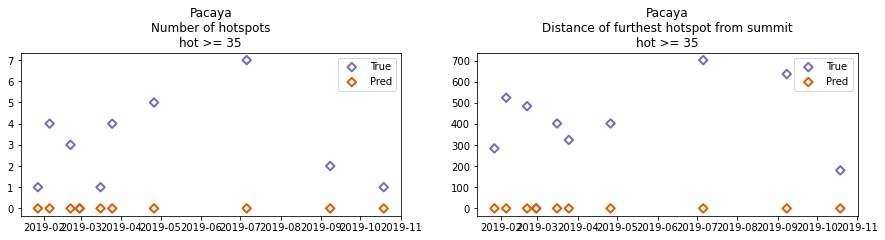

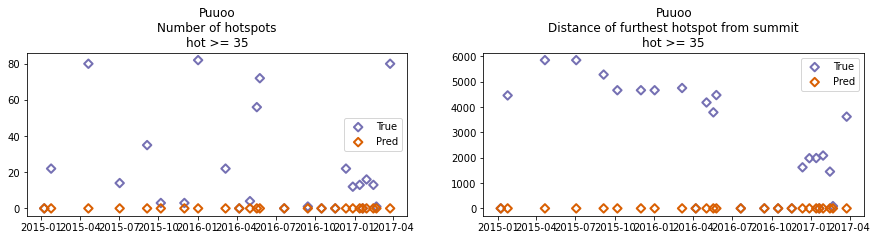

In [15]:
#get_num_hotspots_and_distance_from_summit(true, preds, 10)
#get_num_hotspots_and_distance_from_summit(true, preds, 20)
get_num_hotspots_and_distance_from_summit(true, preds, 35)

# Analysis recreated with post-processed data

In [16]:
template = np.load(train_true)
template.shape

(1127, 1, 1, 96, 96)

In [17]:
# Taken from source code of scikit-image's histogram_matching.py
# Match histogram of predicted validation set images to observed training observations
pred_values, pred_unique_indices, pred_counts = np.unique(preds.ravel(),
                                                          return_inverse=True,
                                                          return_counts=True)
tmpl_values, tmpl_counts = np.unique(template.ravel(), return_counts=True)
pred_quantiles = np.cumsum(pred_counts) / preds.size
tmpl_quantiles = np.cumsum(tmpl_counts) / template.size
interp_a_values = np.interp(pred_quantiles, tmpl_quantiles, tmpl_values)
out = interp_a_values[pred_unique_indices].reshape(preds.shape)

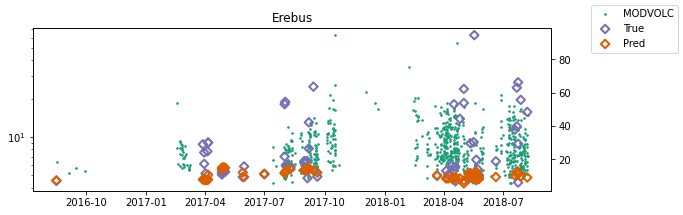

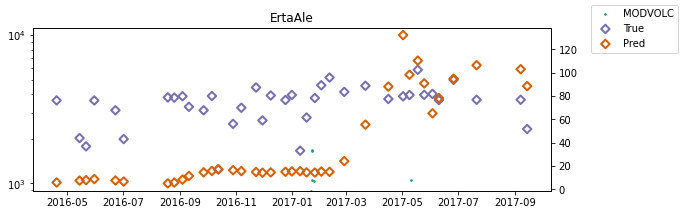

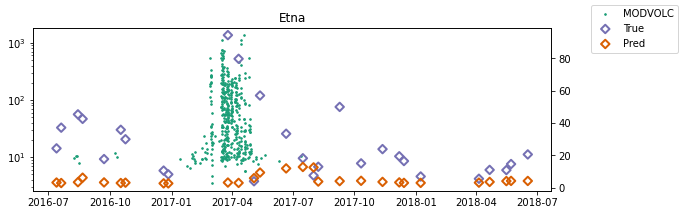

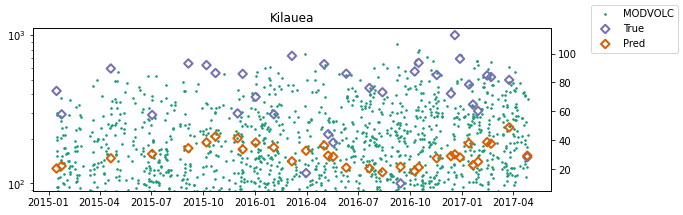

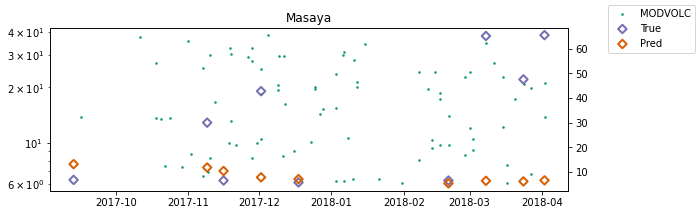

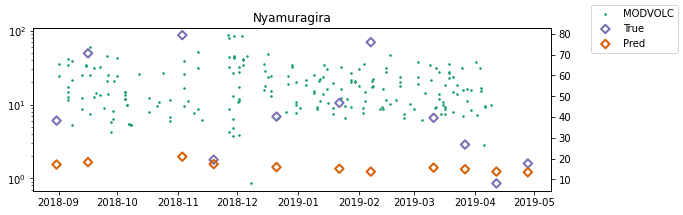

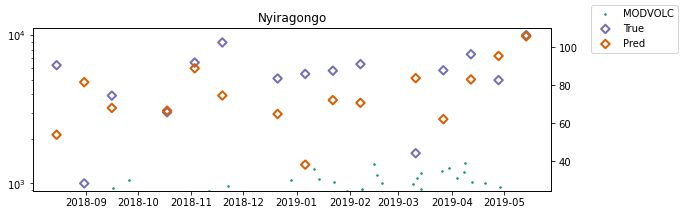

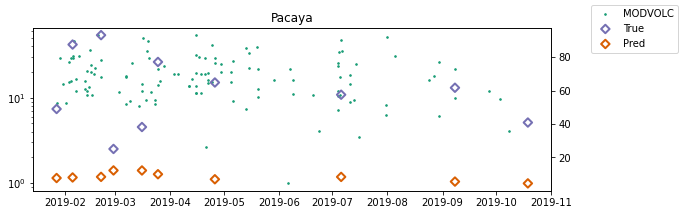

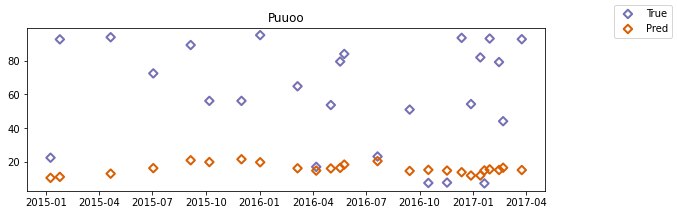

In [18]:
# Maximum temperature - true
max_T_ls = []
for i in range(len(true)):
    max_T_ls.append(np.max(true[i]))
# Maximum temperature - predicted    
max_T_ls2 = []
for i in range(len(out)):
    max_T_ls2.append(np.max(out[i]))

last_break = 0
count = 0
for breaks in breakpoints:
    
    obs_subset = max_T_ls[last_break:breaks]
    pred_subset = max_T_ls2[last_break:breaks]
    
    vol = volcs[count]
    good_df = pd.read_csv('data/' + vol + '/good_df.csv')
    if vol == 'Erebus':
        good_df['acquisition_datetimes'] = [file.split('_')[2] for file in good_df['nighttime_volcano_files']]
        good_df = good_df[good_df.acquisition_datetimes != '00304102013143221'] 
        good_df = good_df[good_df.acquisition_datetimes != '00308162018142109']
        good_df = good_df.reset_index()
    dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in good_df['dates']]
    # Reproducing index choosing from training script
    train_percent = 0.70
    out_samp_perc = 0.15
    num_input_scenes = 6
    train_n = int(np.floor((len(good_df) - num_input_scenes)*train_percent))
    out_n = int(np.floor((len(good_df) - num_input_scenes)*out_samp_perc))
    df_start = train_n + num_input_scenes
    df_end = train_n + out_n + num_input_scenes
    # Getting the dates for the validation sets' y indices
    relevant_dates = dates[df_start:df_end]

    fig, ax1 = plt.subplots()
    fig.set_figheight(3)
    fig.set_figwidth(9)
    fig.subplots_adjust(left = 0, right = 0.8)
    # Getting supplementary modvolc data if available
    if vol != 'Puuoo':
        modvolc_alerts_fn = 'supplementary_data/modvolc_alerts/modis_alert_data_' + vol + '.txt'
        modvolc_alerts_df = pd.read_csv(modvolc_alerts_fn, sep = '\s+')
        modvolc_dates = [datetime.datetime.utcfromtimestamp(date) for date in modvolc_alerts_df['UNIX_Time']]
        ax1.scatter(modvolc_dates, modvolc_alerts_df['Excess'], s = 10, color = '#1b9e77', marker = '.', label = 'MODVOLC')
        ax1.set_yscale('log')
        ax2 = ax1.twinx() 
        ax2.scatter(relevant_dates, obs_subset, label = 'True', linewidth = 2, edgecolor = '#7570b3', color = 'none', marker = 'D')
        ax2.scatter(relevant_dates, pred_subset, label = 'Pred', linewidth = 2, edgecolor = '#d95f02', color = 'none', marker = 'D')
    else:
        ax1.scatter(relevant_dates, obs_subset, label = 'True', linewidth = 2, edgecolor = '#7570b3', color = 'none', marker = 'D')
        ax1.scatter(relevant_dates, pred_subset, label = 'Pred', linewidth = 2, edgecolor = '#d95f02', color = 'none', marker = 'D')
    fig.legend()
    plt.title(vol);
    last_break = breaks
    count += 1

In [19]:
max_T_ls = np.asarray(max_T_ls)
max_T_ls2 = np.asarray(max_T_ls2)
np.sqrt(np.sum((max_T_ls - max_T_ls2)**2) / len(max_T_ls))

39.664355835550815

Metrics for hotspot >= 35
	RMSE for number of hotspots:
		 23.44985785315837
	RMSE for distance of furthest hotspot from summit:
		 1248.9717937834573 



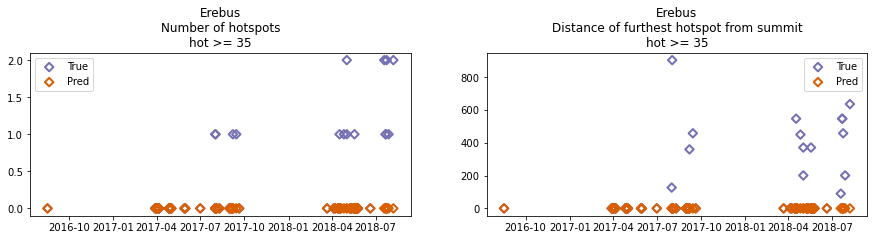

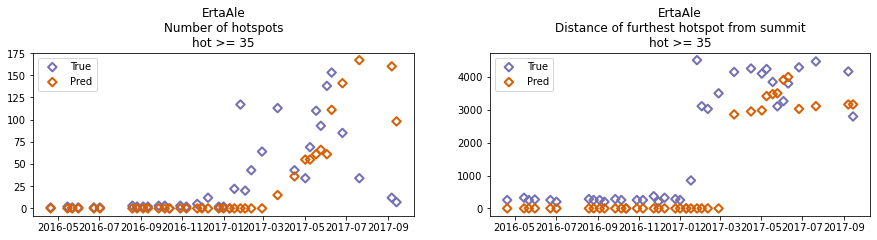

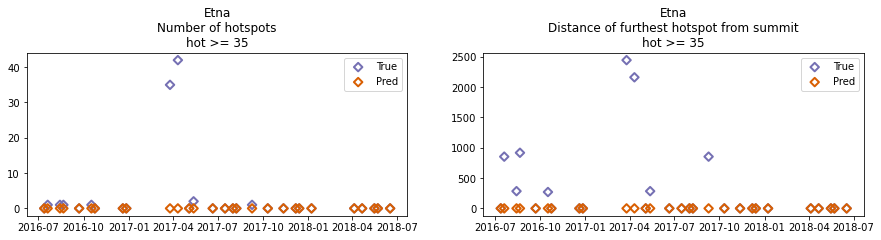

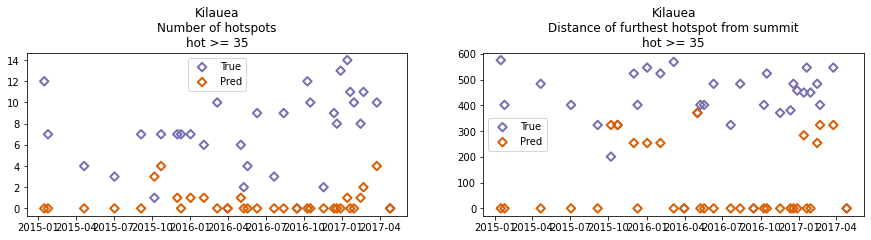

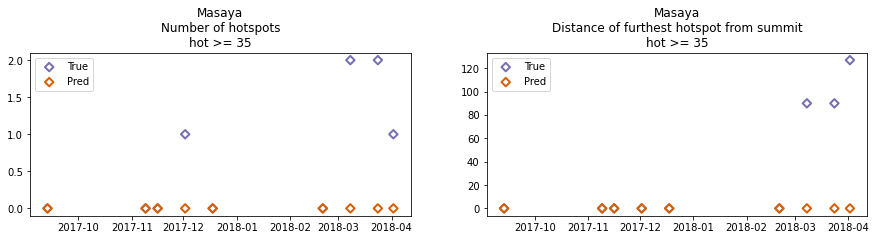

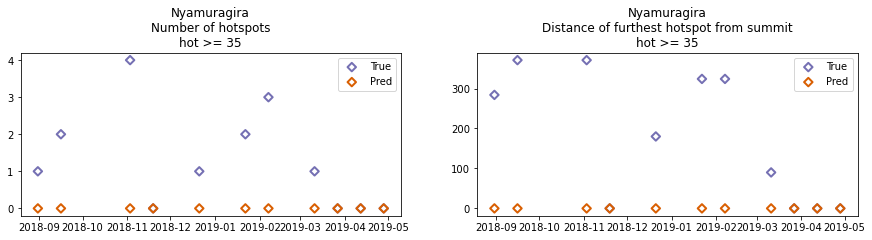

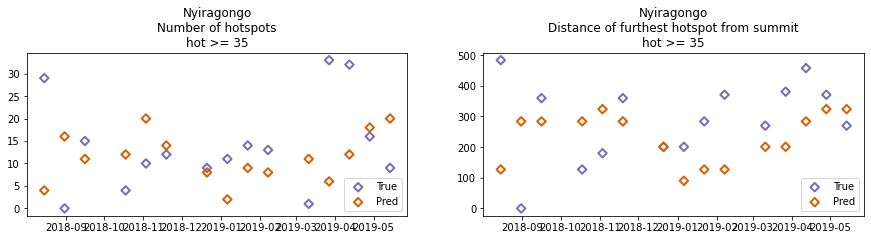

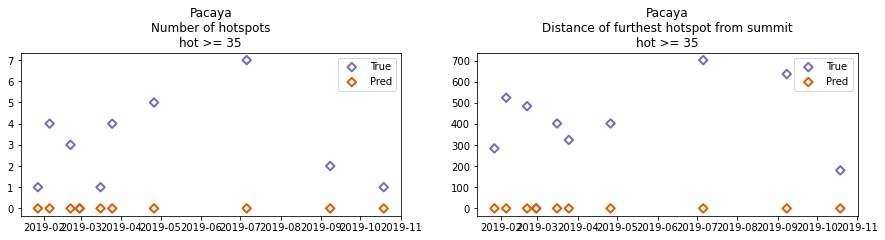

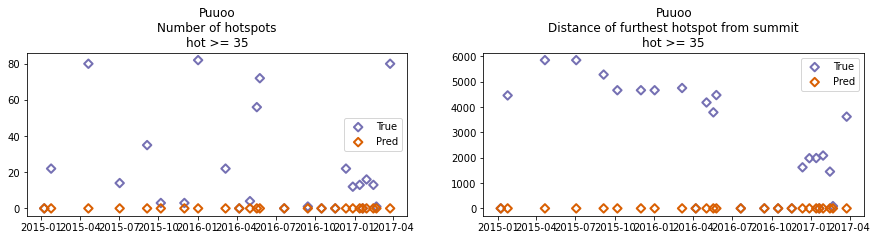

In [20]:
#get_num_hotspots_and_distance_from_summit(true, out, 10)
#get_num_hotspots_and_distance_from_summit(true, out, 20)
get_num_hotspots_and_distance_from_summit(true, out, 35)

# Analysis for active areas

In [21]:
preds2 = preds.copy()
true2 = true.copy()

scene_MSEs = []
scene_SSIMs = []
curr_lower_bound = 0
for i in range(len(preds)):
    mask = np.load("AST_08_data/" + volc_indicator[i] + "/volcanic_features_mask.npy")
    preds2[i, 0] = preds2[i, 0] * mask
    true2[i, 0] = true2[i, 0] * mask
    scene_MSEs.append(np.sum((preds2[i] - true2[i])**2 / mask.sum()))
    scene_SSIMs.append(ssim(np.transpose(preds2[i, 0, 0]), np.transpose(true2[i, 0, 0])))
    if i in breakpoints or i == (len(preds) - 1):
        vol_specific_MSEs = scene_MSEs[curr_lower_bound:i]
        vol_specific_SSIMs = scene_SSIMs[curr_lower_bound:i]
        print(volc_indicator[curr_lower_bound],
              '\n\t RMSE: ', np.sqrt(sum(vol_specific_MSEs) / len(vol_specific_MSEs)),
              '\n\t SSIM: ', sum(vol_specific_SSIMs) / len(vol_specific_SSIMs))
        curr_lower_bound = i
    
print('\n\nTotal:',
      '\n\t RMSE: ', np.sqrt(sum(scene_MSEs) / len(scene_MSEs)),
      '\n\t SSIM: ', sum(scene_SSIMs) / len(scene_SSIMs))

Erebus 
	 RMSE:  5.108879159607764 
	 SSIM:  0.827613978283538
ErtaAle 
	 RMSE:  13.770077229974614 
	 SSIM:  0.9079287634916259
Etna 
	 RMSE:  3.0214488014792313 
	 SSIM:  0.8146705382896238
Kilauea 
	 RMSE:  6.774475379730436 
	 SSIM:  0.8362387555231934
Masaya 
	 RMSE:  7.166084857360291 
	 SSIM:  0.9823948713580458
Nyamuragira 
	 RMSE:  14.651896691465645 
	 SSIM:  0.9882632669270334
Nyiragongo 
	 RMSE:  28.83251965501065 
	 SSIM:  0.9812240049296229
Pacaya 
	 RMSE:  3.7178349883884048 
	 SSIM:  0.9810467830897156
Puuoo 
	 RMSE:  3.9656841521163946 
	 SSIM:  0.8146067126685527


Total: 
	 RMSE:  10.617076127331549 
	 SSIM:  0.8677907393631712


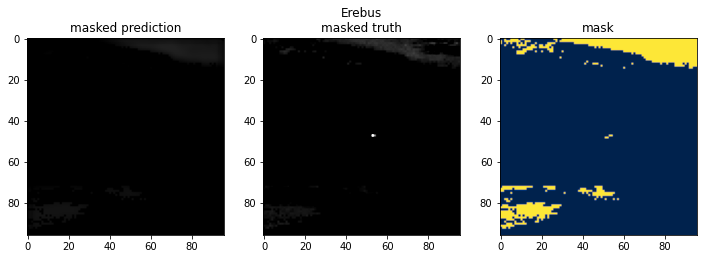

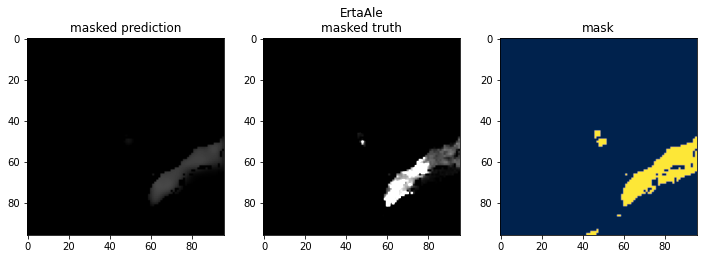

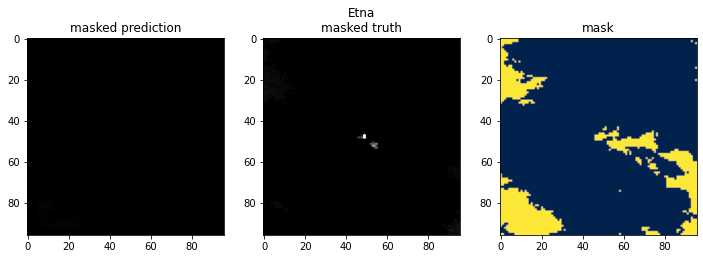

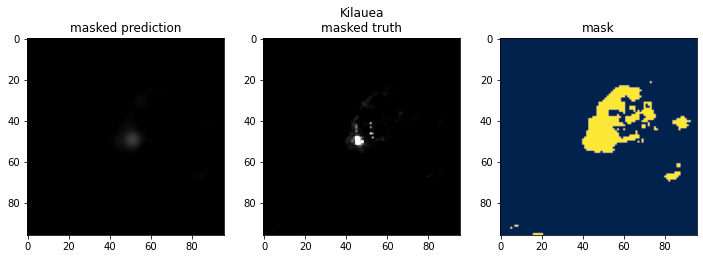

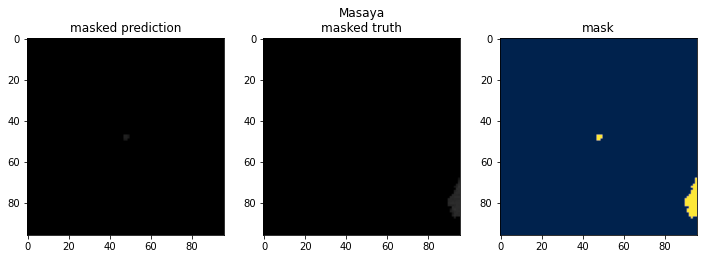

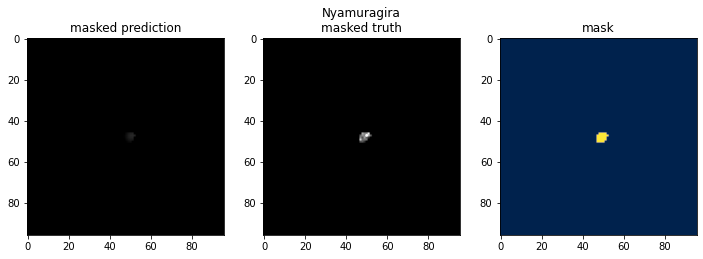

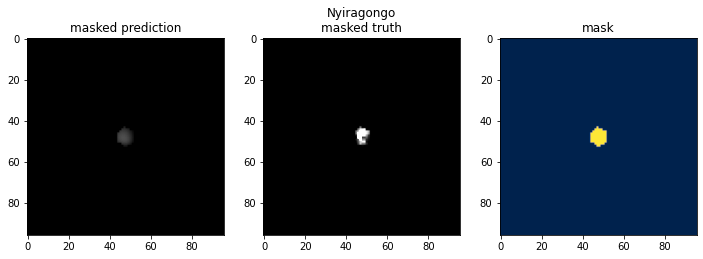

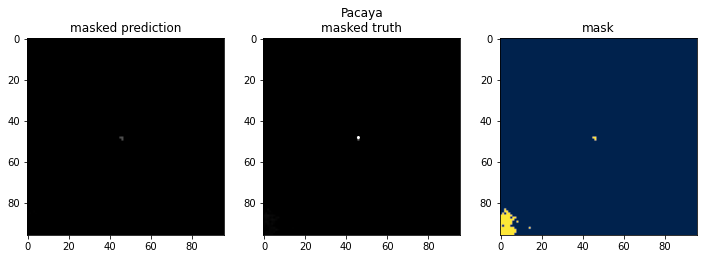

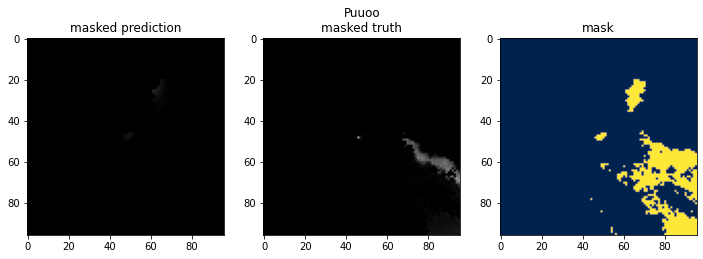

In [22]:
#interesting_indices = [0, 39, 87, 103, 118, 135, 151, 192, 234]
interesting_indices = [30, 103, 119, 160, 170, 184, 203, 203, 228]
count = 0
last_break = 0
for i in volcs:
    mask = np.load("AST_08_data/" + i + '/volcanic_features_mask.npy')
    scene_i = interesting_indices[count]

    f, axarr = plt.subplots(1,3)
    f.set_figheight(4)
    f.set_figwidth(12)
    axarr[0].set_title('masked prediction')
    axarr[0].imshow(preds[scene_i, 0, 0] * mask, vmin = 0, vmax = 35)
    axarr[1].imshow(true[scene_i, 0, 0] * mask, vmin = 0, vmax = 35)
    axarr[1].set_title(i+'\nmasked truth')
    axarr[2].imshow(mask, cmap = 'cividis')
    axarr[2].set_title('mask')  
    
    last_break = breakpoints[count]
    count += 1